In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX


### Read in and convert to date to datetime

In [2]:
sales = pd.read_csv('training_Sales.csv')
#traffic = pd.read_csv('training_Traffic.csv')

In [3]:
# convert to datatime
sales['Date'] = pd.to_datetime(sales['Date'])
sales.set_index('Date', inplace = True)
sales.sort_index(inplace = True)
sales.columns = ['sales']
sales.head()

,sales
Date,
2013-11-07 13:00:00,830
2013-11-07 13:15:00,885
2013-11-07 13:30:00,938
2013-11-07 13:45:00,804
2013-11-07 14:00:00,793


## Explore the data

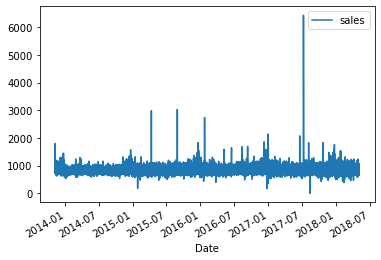

In [4]:
sales.plot();

 The initial plot is hard to interpret.  There seems to be some spikes, and one very large sales day

In [5]:
#Since we are predicting June 2018 look at June 2017
prev_month_total = sales['2017-06'].resample('d').sum().dropna()
prev_month_total

,sales
Date,
2017-06-01,32374
2017-06-02,33793
2017-06-03,35803
2017-06-04,26336
2017-06-05,31970
2017-06-06,32515
2017-06-07,35050
2017-06-08,34255
2017-06-09,35783


In [6]:
prev_month_total.describe()

,sales
count,30.000000
mean,33138.600000
std,3079.325717
min,25015.000000
25%,32409.250000
50%,33855.000000
75%,35192.750000
max,37589.000000


In [7]:
#look at the mean sales for each day of the previous years month
prev_month_mean = sales['2017-06'].resample('d').mean().dropna()
prev_month_mean.describe()

,sales
count,30.000000
mean,803.912942
std,23.513583
min,770.809524
25%,786.828224
50%,798.487224
75%,815.481312
max,854.295455


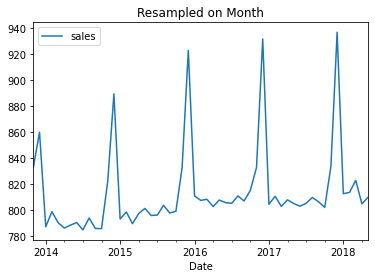

In [8]:
sales_month = sales.resample('M').mean()
sales_month.plot()
plt.title('Resampled on Month');

When we look at the Monthly mean we can clearly see a seasonal pattern and trend.  Every December there is a huge spike in sales and there is an increase in sales year over year from 2014 to 2018 although it has leveled off some from 2016 to 2018.

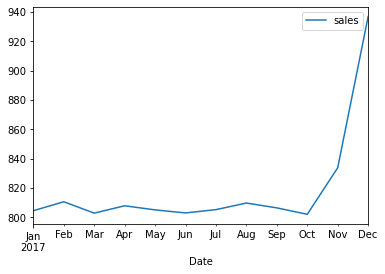

In [9]:
sales_2017 = sales['2017'].resample('M').mean()
sales_2017.plot();

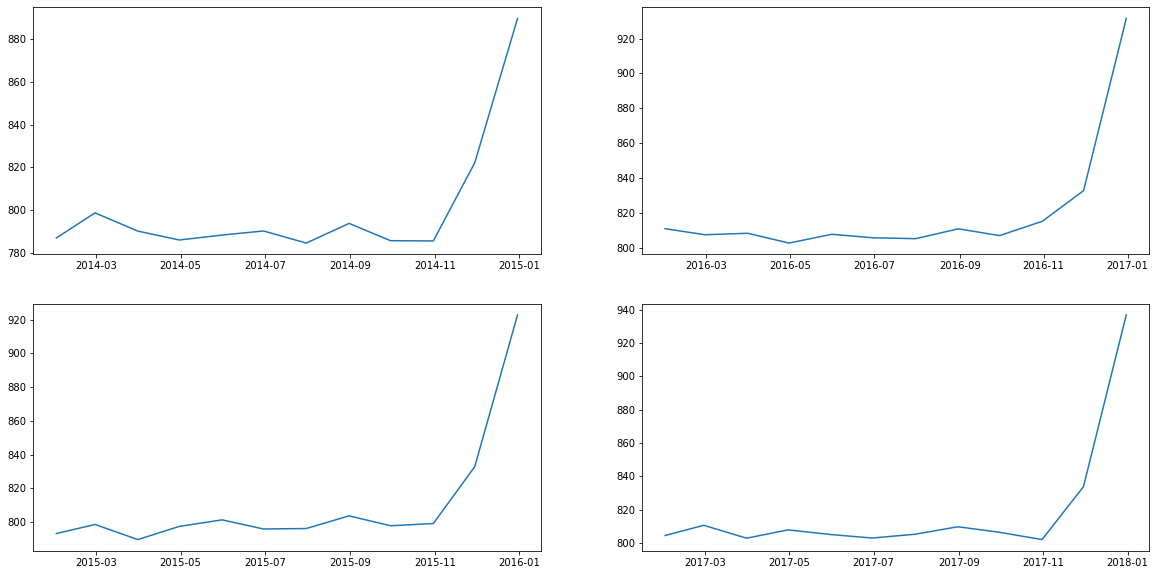

In [10]:
fig, ax = plt.subplots(2,2, figsize=(20,10))


ax[0,0].plot(sales['2014'].resample('M').mean())

ax[1,0].plot(sales['2015'].resample('M').mean())
ax[0,1].plot(sales['2016'].resample('M').mean())
ax[1,1].plot(sales['2017'].resample('M').mean())
plt.show();

Investigating the other 3 cyclic spikes in sales they appear to be every August and then in early spring/summer (April, May, or June) and at the begining of the year in February.

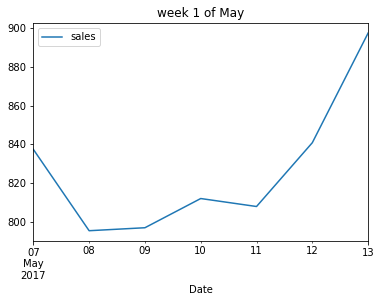

In [11]:
#What does a typical week look like (Sunday to Saturday)
sales_2017_week = sales.loc['2017-05-07': '2017-05-13'].resample('D').mean()
sales_2017_week.plot()
plt.title('week 1 of May');

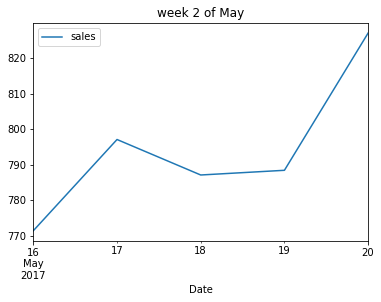

In [12]:
sales_2017_week = sales.loc['2017-05-16': '2017-05-20'].resample('D').mean()
sales_2017_week.plot()
plt.title('week 2 of May');

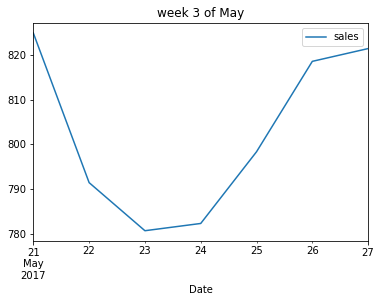

In [13]:
sales_2017_week = sales.loc['2017-05-21': '2017-05-27'].resample('D').mean()
sales_2017_week.plot();
plt.title('week 3 of May');

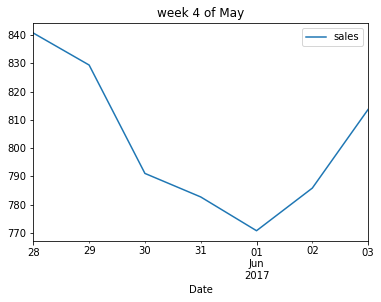

In [14]:
sales_2017_week = sales.loc['2017-05-28': '2017-06-03'].resample('D').mean()
sales_2017_week.plot()
plt.title('week 4 of May');

### Looking at each week from the previous year (2017) for the month of June we see strongest sales on Sunday and weakest sales Monday and Tuesday with a general recovery toward the end of the week

In [15]:
# number of days in dataset
unique_days = sales.index.normalize().value_counts()
unique_days

2013-12-23    69
2014-11-28    67
2016-12-23    67
2014-12-23    65
2017-11-24    65
              ..
2014-01-19    27
2014-03-30    27
2014-04-27    27
2014-02-02    26
2013-11-07    11
Name: Date, Length: 1623, dtype: int64

### Find min and max time looking for typical store hours

In [16]:
#original thought was looking for store core hours.  Look at how many rows match each hour
match = "19:00:00"
sales.loc[sales.index.strftime("%H:%M:%S") == match]

,sales
Date,
2013-11-08 19:00:00,775
2013-11-09 19:00:00,890
2013-11-10 19:00:00,1156
2013-11-11 19:00:00,731
2013-11-12 19:00:00,908
...,...
2018-05-02 19:00:00,742
2018-05-03 19:00:00,840
2018-05-04 19:00:00,929


In [17]:
sales.shape

(67058, 1)

In [18]:
sales.describe()

,sales
count,67058.000000
mean,815.701631
std,100.306658
min,0.000000
25%,754.000000
50%,793.000000
75%,851.000000
max,6435.000000


### Investigate the max value of 6435

In [19]:
top = sales.sort_values('sales', ascending = False)
top.columns = ['sales']
top.head(10)

,sales
Date,
2017-07-09 19:15:00,6435
2015-08-29 14:00:00,3027
2015-04-11 14:15:00,2987
2016-01-23 14:15:00,2740
2016-12-31 17:00:00,2144
2017-06-19 15:30:00,2075
2017-06-19 15:45:00,1950
2016-12-09 22:45:00,1860
2015-12-19 13:00:00,1832


In [20]:
#look at the rest of that day.  Was it a big sales day
big_day = sales['2017-07-09']
big_day

,sales
Date,
2017-07-09 10:45:00,739
2017-07-09 11:00:00,773
2017-07-09 11:15:00,733
2017-07-09 11:30:00,829
2017-07-09 11:45:00,767
2017-07-09 12:00:00,782
2017-07-09 12:15:00,902
2017-07-09 12:30:00,764
2017-07-09 12:45:00,801


### Resample to hourly

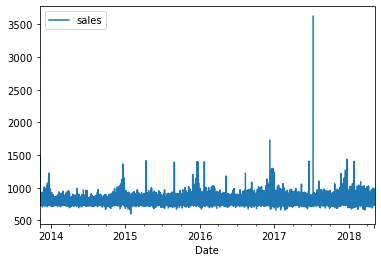

In [21]:
#Because we are projecting every hour we will resample to be in the same units
sales_rs = sales.resample('H').mean()
sales_rs.plot();

In [22]:
sales_rs.head()

,sales
Date,
2013-11-07 13:00:00,864.25
2013-11-07 14:00:00,750.00
2013-11-07 15:00:00,NaN
2013-11-07 16:00:00,729.00
2013-11-07 17:00:00,NaN


As we can see this created a lot of null values

In [23]:
sales_rs.shape

(39391, 1)

In [24]:
sales_rs.isna().sum()

sales    20571
dtype: int64

In [25]:
#check number of nulls in core hours
sales_rs_day = sales_rs.between_time('11:00:00' , '19:00:00')
sales_rs_day.isna().sum()

sales    253
dtype: int64

In [26]:
sales_rs.head()

,sales
Date,
2013-11-07 13:00:00,864.25
2013-11-07 14:00:00,750.00
2013-11-07 15:00:00,NaN
2013-11-07 16:00:00,729.00
2013-11-07 17:00:00,NaN


In [27]:
sales_rs.isna().sum()

sales    20571
dtype: int64

In [28]:
sales_rs.dropna(inplace=True)

In [29]:
sales_rs.shape

(18820, 1)

In [30]:
sales_rs.isna().sum()

sales    0
dtype: int64

### Do I need to Diff??

In [31]:
#Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

adfuller(sales_rs)

(-10.36368295282687,
 2.3604244586118723e-18,
 45,
 18774,
 {'1%': -3.4306983644579865,
  '5%': -2.861693964293079,
  '10%': -2.5668519510824446},
 204259.5035984037)

In [32]:
#The p-value is the second value: 9.38 e-21
#This is sufficiently below .05 and the data does not need to be diff for stationarity

## Look at Autocorrelation and P ACF

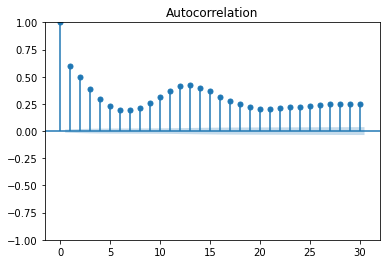

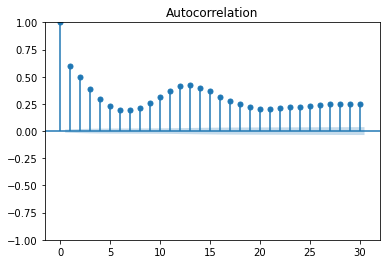

In [36]:
plot_acf(sales_rs['sales'], lags = 30)

C:\Users\eswan\anaconda3\envs\projects\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


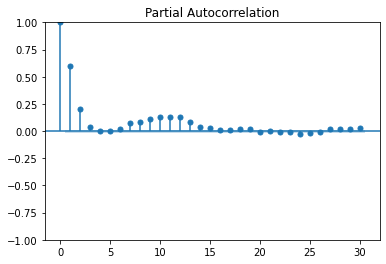

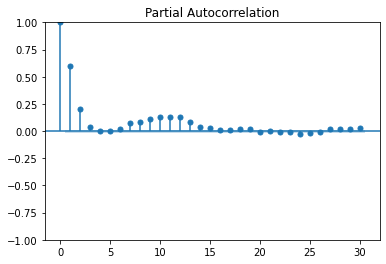

In [34]:
plot_pacf(sales_rs['sales'], lags = 30)

## Base Model

In [37]:
#forecast using the dataset mean since we are projecting so much data into the future
base_model = sales.copy()
base_model['forecast_sales'] = 815
base_model.head()

,sales,forecast_sales
Date,,
2013-11-07 13:00:00,830,815
2013-11-07 13:15:00,885,815
2013-11-07 13:30:00,938,815
2013-11-07 13:45:00,804,815
2013-11-07 14:00:00,793,815


In [39]:
base_model_error = mean_squared_error(base_model.sales, base_model.forecast_sales)
np.sqrt(base_model_error)

100.30836407006565

## Build the model

In [40]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
sales_train = sales_rs.sales.loc[:'2018-04-05 19:00:00']
sales_test = sales_rs.sales.loc['2018-04-06 10:15:00': '2018-05-06 19:00:00']

In [43]:
len(sales_test)

356

## SARIMAX

In [109]:
model = SARIMAX(sales_train, order=(3, 1, 2),
              seasonal_order=(2, 1, 0, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)
results = model.fit()

In [45]:
len(sales_test)

356

In [83]:
forecast = results.predict(start = len(sales_train),
                           end=len(sales_train)+365,
                           typ='levels').rename('Predict')

In [47]:
forecast_df = pd.DataFrame(forecast)
forecast_df.reset_index(drop=True, inplace=True)
forecast_df.head()

,Predict
0,773.083291
1,835.451690
2,777.053428
3,779.915620
4,761.199633


In [71]:
#Create a df with test size values
new = pd.DataFrame(sales_test)
new['date'] = new.index
new.reset_index(drop=True, inplace=True)
new.head()

,sales,date
0,789.25,2018-04-06 11:00:00
1,867.00,2018-04-06 12:00:00
2,770.50,2018-04-06 13:00:00
3,867.00,2018-04-06 14:00:00
4,826.00,2018-04-06 15:00:00


In [72]:
results = pd.concat([new, forecast_df], axis=1)
results.set_index('date', inplace=True)
results.head()

,sales,Predict
date,,
2018-04-06 11:00:00,789.25,773.083291
2018-04-06 12:00:00,867.00,835.451690
2018-04-06 13:00:00,770.50,777.053428
2018-04-06 14:00:00,867.00,779.915620
2018-04-06 15:00:00,826.00,761.199633


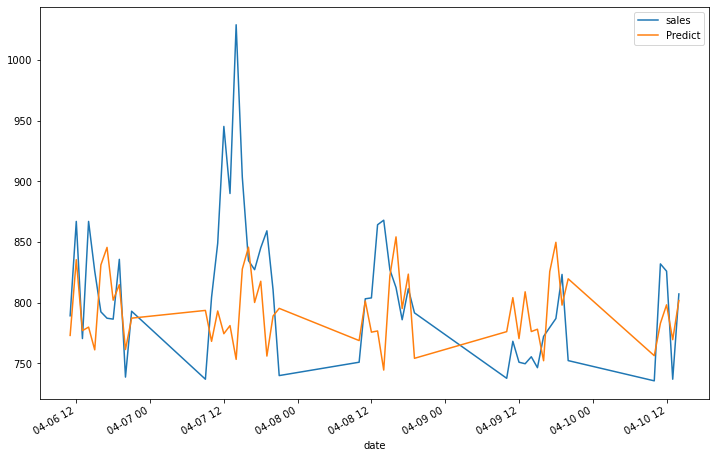

In [73]:
results['sales'][:50].plot(figsize=(12,8),legend=True)
results['Predict'][:50].plot(legend=True);

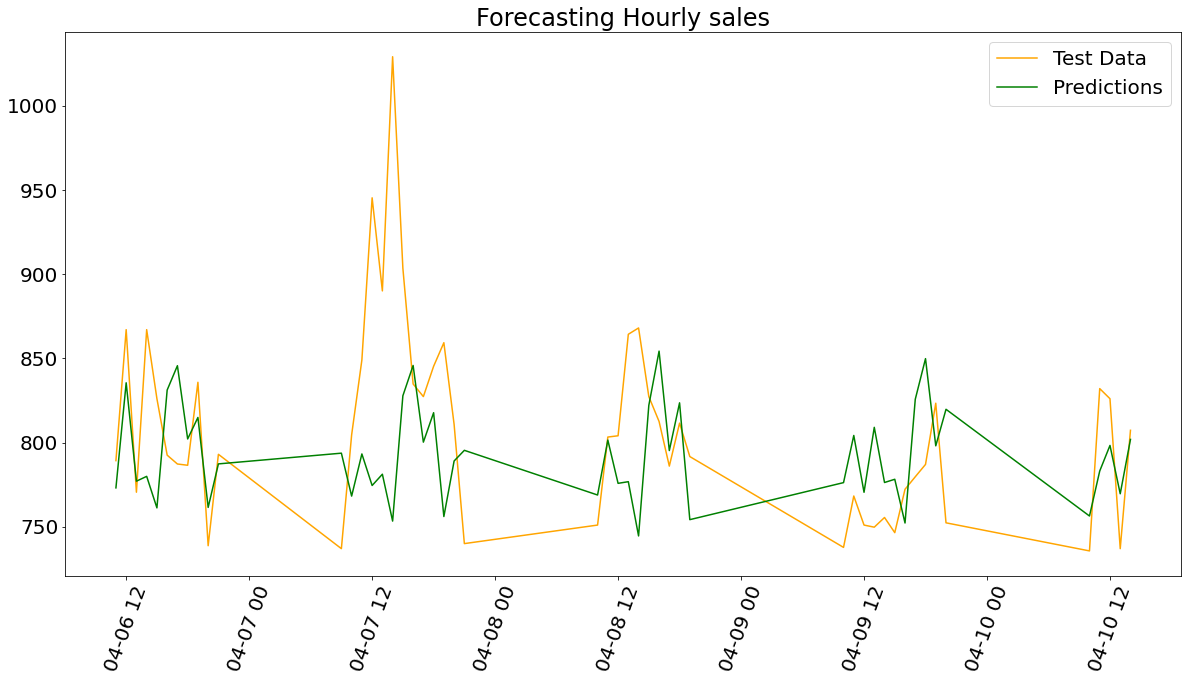

In [75]:
plt.figure(figsize=(20,10))

# Plot testing data.
plt.plot(results['sales'][:50], color = 'orange', label='Test Data')

# Plot predicted test values.
plt.plot(results['Predict'][:50], color = 'green', label='Predictions')

# Set label.
plt.title(label = 'Forecasting Hourly sales', fontsize=24)

# Resize tick marks.
plt.xticks(fontsize=20,rotation=70)
plt.yticks(fontsize=20)

plt.legend(loc='best', prop={'size': 20});

In [54]:
results.isna().sum()

sales      10
Predict     0
dtype: int64

In [58]:
results.dropna(inplace=True)

In [59]:
mean_squared_error(results['sales'], results['Predict']) ** 0.5

59.85735035881236

In [110]:
forecast_sales_may = results.predict(start = len(sales_rs),
                           end=len(sales_rs)+722,
                           typ='levels').rename('Sales_Predict')

In [111]:
forecast_sales_may

18820    797.555908
18821    768.167698
18822    801.929601
18823    774.347994
18824    776.050799
            ...    
19538    749.637596
19539    776.454557
19540    793.548099
19541    764.159889
19542    797.921792
Name: Sales_Predict, Length: 723, dtype: float64

In [112]:
forecast_May_df = pd.DataFrame(forecast_sales_may)
forecast_May_df.reset_index(drop=True, inplace=True)
forecast_May_df.head()

,Sales_Predict
0,797.555908
1,768.167698
2,801.929601
3,774.347994
4,776.050799


In [113]:
#Create a dataframe with the dates to forecast
sales_forecast = pd.DataFrame({'Hours': pd.date_range('2018-05-06 22:00:00', '2018-06-06', freq='1H', closed='left')})
sales_forecast.head()

,Hours
0,2018-05-06 22:00:00
1,2018-05-06 23:00:00
2,2018-05-07 00:00:00
3,2018-05-07 01:00:00
4,2018-05-07 02:00:00


In [114]:
len(sales_forecast)

722

In [119]:
results = pd.concat([sales_forecast, forecast_May_df], axis=1)
results.set_index('Hours', inplace=True)
results.head()

,Sales_Predict
Hours,
2018-05-06 22:00:00,797.555908
2018-05-06 23:00:00,768.167698
2018-05-07 00:00:00,801.929601
2018-05-07 01:00:00,774.347994
2018-05-07 02:00:00,776.050799


In [106]:
len(results)

366

In [120]:
results.to_csv('sales_prediction.csv')

In [121]:
#check format is okay
sales_predicitons = pd.read_csv('sales_prediction.csv')
sales_predicitons.head()

,Hours,Sales_Predict
0,2018-05-06 22:00:00,797.555908
1,2018-05-06 23:00:00,768.167698
2,2018-05-07 00:00:00,801.929601
3,2018-05-07 01:00:00,774.347994
4,2018-05-07 02:00:00,776.050799
